# Modeling the Dataset

Let's summarize our findings and Train the Data on the Training Dataset.

I trained and optimized the following models:

- Logistic Regression
- Perceptron
- KNN
- SVM
- Bagging
- Decission Tree
- Random Forest
- Extremly Random Forest
- Gradient Boosting
- Extreme Gradient Boosting

In [1]:
# General Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the Datasets
train = pd.read_csv('data/train_clean.csv', index_col=0)
test = pd.read_csv('data/test_clean.csv', index_col=0)

In [3]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Child,Young,Young_m,Young_f,Cabin_known,Age_known,Family,Alone,LargeFamily,Deck,Bad_ticket,Fare_cat
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,2,0,1,1,0,0,1,1,0,0,8,1,0
2,1,1,0,38.0,1,0,71.2833,0,0,1,0,1,1,1,1,0,0,2,0,1
3,1,3,0,26.0,0,0,7.9250,2,0,1,0,1,0,1,0,1,0,8,0,0
4,1,1,0,35.0,1,0,53.1000,2,0,1,0,1,1,1,1,0,0,2,0,1
5,0,3,1,35.0,0,0,8.0500,2,0,1,1,0,0,1,0,1,0,8,1,0


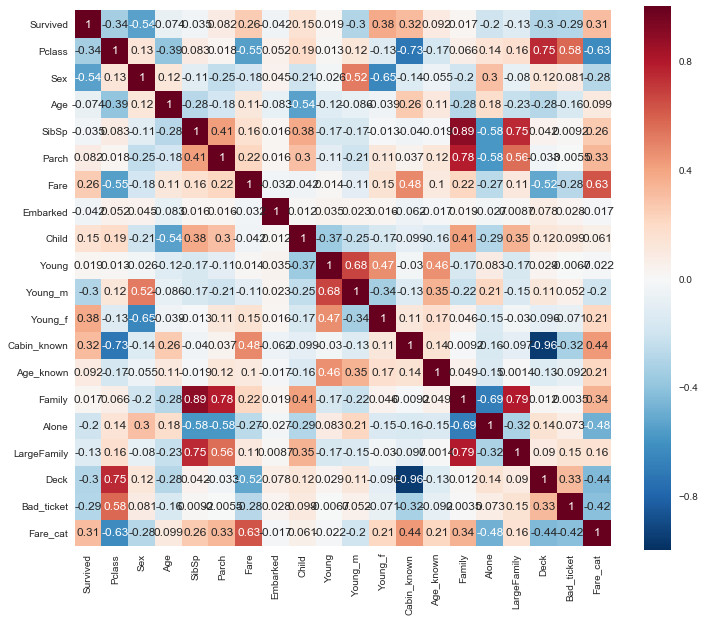

In [4]:
plt.subplots(figsize=(12,10))
sns.heatmap(train.corr(), vmax=1.0, square=True, annot=True);

In [5]:
# Creating Test-Train Splits for Model Training
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

training, testing = train_test_split(train,test_size=0.2, random_state=0)

In [6]:
print('Total training size = %i; training set size =%i; testset size =%i'%(train.shape[0], training.shape[0], testing.shape[0]))

Total training size = 891; training set size =712; testset size =179


##  First Look at the Models
Now we are ready to model the Data. I will start with *Logistic Regression* to get a good feeling for the individual importance of each feature.

In [7]:
cols = ['Sex', 'Pclass', 'Cabin_known', 'LargeFamily', 'Parch', 'SibSp', 'Young', 'Alone', 'Young_f', 'Young_m']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
x = df.loc[:, cols]
y = np.ravel(df.loc[:,['Survived']])

In [8]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(x,y)
score_log = clf_log.score(x,y)
print(score_log)

0.806179775281


In [9]:
pd.DataFrame(list(zip(x.columns, np.transpose(clf_log.coef_))))

,0,1
0,Sex,[-2.32974584604]
1,Pclass,[-0.446009349642]
2,Cabin_known,[0.683997879647]
3,LargeFamily,[-1.45490528154]
4,Parch,[0.0756113550014]
5,SibSp,[-0.122526914536]
6,Young,[0.0460225600503]
7,Alone,[-0.212838644742]
8,Young_f,[0.175740673407]
9,Young_m,[-0.129718113357]


### Run and describe several different classifiers
Based on the first look let's define the input columns and create the training and testing feature sets

In [10]:
# Import Models
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [11]:
# Select the relevant Features
cols = ['Sex', 'Pclass', 'Cabin_known', 'LargeFamily', 'Young', 'Alone', 'Child']
tcols = np.append(['Survived'],cols)

# Create the Training
df = training.loc[:,tcols].dropna()
X = df.loc[:, cols]
y = np.ravel(df.loc[:,'Survived'])

# Create the Testset
df = testing.loc[:,tcols].dropna()
X_test = df.loc[:, cols]
y_test = np.ravel(df.loc[:, 'Survived'])

In [12]:
print(X_test.shape[0] == y_test.shape[0])
print(X.shape[0]==y.shape[0])

True
True


#### Logistic Regression
This time with the selected Columns

In [13]:
clf_log = LogisticRegression().fit(X,y)
score_log = cross_val_score(clf_log, X,y, cv=5).mean()
print(score_log)

0.799307614771


#### Perceptron

In [14]:
clf_pctr = Perceptron(class_weight='balanced').fit(X,y)
score_pctr = cross_val_score(clf_pctr, X,y, cv=5).mean()
print(score_pctr)

0.73454577587


#### K Nearest Neighbors:

In [15]:
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
).fit(X,y)
score_knn = cross_val_score(clf_knn, X, y, cv=5).mean()
print(score_knn)

0.807600031574


#### Support Vector Machine:

In [16]:
clf_svm = SVC(class_weight='balanced', kernel='rbf').fit(X,y)
score_svm = cross_val_score(clf_svm, X, y, cv=5).mean()

#### Bagging:


In [74]:
bagging = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=2,
        weights='distance'
    ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
)
clf_bag = bagging.fit(X,y)
score_bag = clf_bag.oob_score_
print(score_bag)

0.806179775281


**Bagging** is a general ensemble method. This means it's a way to average over a (large) number of individual classifiers to improve their accuracy by reducing the variance (= noise). The estimator (above it's a KNN) is used multiple times on subsets of the training sample and then it uses the average vote.<br>
<br>
Bagging for a decision tree classifier should be the same as using a Random Forest (see below).<br><br>
Strictly speaking, bagging is only the correct term if the sub samples are drawn with replacement (i.e. put back into the bag, I suppose). Otherwise it's called Pasting.
If sub-samples are used then the remaining samples (the ones not in the bag we're drawing the data from) can be used in out-of-bag (oob) estimates (-> oob_score=True). This is a kind of inbuilt cross-validation step, since the accuracy (score) of the classifier is estimated on data it wasn't trained on.


#### Decision Tree:

In [18]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf=0.01
)
clf_tree = clf_tree.fit(X,y)
score_tree = cross_val_score(clf_tree, X, y, cv=5).mean()
print(score_tree)

0.806270654727


#### Random Forest:

The random in random forest comes from the method of training each tree using a random bootstrap sample (i.e. one with replacement) of the original training set. Further randomness is introduced by making the node split dependent on a random subset of features instead of all of them. Here single trees are combined through the average of the prediction probabilities.
In addition to the tree parameters, the most important settings are:
n_estimators: number of trees. The larger the better, although improvements become marginal eventually
max_features: number of random features per subset. Lower numbers decrease variance and increase bias. Rule of thumb for classification: max_features = sqrt(all_features). This is the default setting.
One suggestion is to use a large number of highly overfitted trees with small split limits and no depth limit.

In [19]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
#     min_samples_split=5,
#     class_weight='balanced',
)
clf_rf = clf_rf.fit(X,y)
score_rf = cross_val_score(clf_rf, X, y, cv=5).mean()
print(score_rf)

0.810397234371


#### Extremly randomized Trees:

Extremely Randomised Trees is an ensemble classifier similar to random forests. An additional randomness is introduced by selecting random thresholds for each feature and using the best-performing threshold.


In [20]:
from sklearn.ensemble import ExtraTreesClassifier
clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
).fit(X,y)

In [21]:
score_ext = cross_val_score(clf_ext, X, y, cv=5).mean()
print(score_ext)

0.811795835769


#### Gradient Boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

clf_gb = GradientBoostingClassifier(
    loss='exponential',
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.5,
    random_state=0
).fit(X,y)

In [23]:
score_gb = cross_val_score(clf_gb, X, y, cv=5).mean()
print(score_gb)

0.811756298841


#### Extreme Gradient Boosting

To be able to actually work with the Package we need to append the root to the Python Path

In [24]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [25]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
).fit(X,y)

In [26]:
score_xgb = cross_val_score(clf_xgb, X, y, cv=5).mean()
print(score_xgb)

0.814701939754


## Optimising one classifier in more detail:

### Tuning Model Hyperparameter with GridSearchCV

In [30]:
from sklearn.model_selection import GridSearchCV
clf_ext = ExtraTreesClassifier(max_features='auto', oob_score=True, bootstrap=True)
param_grid = {'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [1, 5, 10],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [20, 50, 100]}
gs = GridSearchCV(clf_ext, param_grid=param_grid, scoring='accuracy', cv=3).fit(X,y)

In [31]:
print(gs.best_score_)
print(gs.best_params_)

0.818820224719
{'criterion': 'gini', 'n_estimators': 100, 'min_samples_leaf': 5, 'min_samples_split': 8}


In [32]:
clf_ext = ExtraTreesClassifier(
    max_features=True,
    bootstrap=True,
    oob_score=True,
    criterion='gini',
    min_samples_leaf=5,
    min_samples_split=8,
    n_estimators=50
).fit(X,y)
score_ext = clf_ext.score(X,y)
print(score_ext)
pd.DataFrame(list(zip(X.columns, np.transpose(clf_ext.feature_importances_)))).sort_values(1, ascending=False)

0.838483146067


,0,1
0,Sex,0.495708
1,Pclass,0.149278
2,Cabin_known,0.104090
6,Child,0.093393
3,LargeFamily,0.073654
5,Alone,0.062070
4,Young,0.021808


In [34]:
cross_val_score(gs.best_estimator_, X, y, cv=5).mean()

0.81469223015522085

### Applying a confusion matrix

In [54]:
from sklearn.metrics import confusion_matrix


def show_confusion_matrix(cnf_matrix, class_labels):
    plt.matshow(cnf_matrix,cmap=plt.cm.YlGn, alpha=0.7)
    ax = plt.gca()
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks(range(0,len(class_labels)))
    ax.set_xticklabels(class_labels, rotation=45)
    ax.set_ylabel('Actual Label', fontsize=16,rotation=90 )
    ax.set_yticks(range(0,len(class_labels)))
    ax.set_yticklabels(class_labels)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    plt.grid(False)
    
    for row in range(len(cnf_matrix)):
        for col in range(len(cnf_matrix[row])):
            ax.text(col, row, cnf_matrix[row][col], va='center', ha='center', fontsize=16)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Conusion matrix, without normalization')
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    
class_names = ['Dead', 'Alive']
cnf_matrix = confusion_matrix(clf_ext.predict(X_test), y_test)

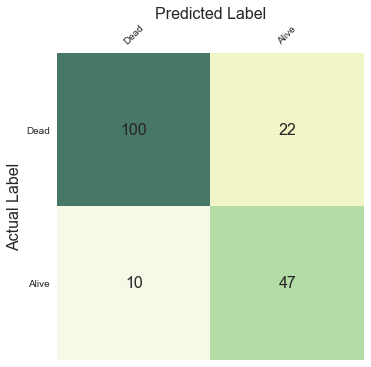

In [55]:
show_confusion_matrix(cnf_matrix, class_names)

Conusion matrix, without normalization
[[100  22]
 [ 10  47]]


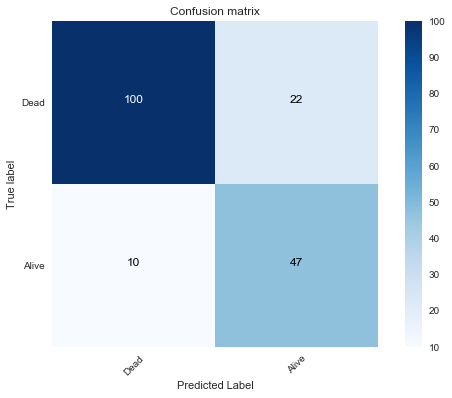

In [66]:
plot_confusion_matrix(cnf_matrix, class_names, normalize=False, cmap=plt.cm.Blues)

### Model validation

To ensure we are not overfitting random Datapoint we then check the model in cross validation.

In [72]:
scores = cross_val_score(clf_ext, X, y, cv=20)
scores_test = clf_ext.score(X_test, y_test)
print('Mean score= %.3f, Std deviation = %.3f'%(np.mean(scores), np.std(scores)))
print('Testscore = %.3f'%(scores_test))

Mean score= 0.819, Std deviation = 0.054
Testscore = 0.821


## Rank the Models and features

After we collected all the models performance on the Training Data, we can now go and display their ranking. This can be rerun as a whole pipeline after we have adapted an individual Model trough hyperparameter tuning.

In [78]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
             'Random Forest', 'Gradient Boosting', 'Bagging KNN',
             'Decision Tree', 'XGBoost', 'ExtraTree', 'Perceptron'],
    'Score': [score_svm, score_knn, score_log, score_rf, score_gb, score_bag,
             score_tree, score_xgb, score_ext, score_pctr]})
models.sort_values(by='Score', ascending=False)

,Model,Score
8,ExtraTree,0.838483
0,Support Vector Machines,0.828748
7,XGBoost,0.814702
4,Gradient Boosting,0.811756
3,Random Forest,0.810397
1,KNN,0.807600
6,Decision Tree,0.806271
5,Bagging KNN,0.806180
2,Logistic Regression,0.799308
9,Perceptron,0.734546


We can also analyze the Feature Importance that each Algorithm assigned, to get a bit more insight into what is going on.

In [84]:
summary = pd.DataFrame(list(zip(X.columns,
                                np.transpose(clf_tree.feature_importances_),
                                np.transpose(clf_rf.feature_importances_),
                                np.transpose(clf_ext.feature_importances_),
                                np.transpose(clf_gb.feature_importances_),
#                                 np.transpose(clf_ada.feature_importances_),
                                np.transpose(clf_xgb.feature_importances_),
                               )), columns=['Feature', 'Tree', 'RF', 'Extra', 'GB', 'Xtreme'])
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,Tree,RF,Extra,GB,Xtreme,Median
0,Sex,0.606860,0.494137,0.495708,0.186202,0.173196,0.494137
1,Pclass,0.156942,0.160605,0.149278,0.183855,0.220619,0.160605
2,Cabin_known,0.001233,0.085118,0.104090,0.095981,0.114089,0.095981
6,Child,0.084372,0.095015,0.093393,0.114100,0.109966,0.095015
3,LargeFamily,0.113576,0.073563,0.073654,0.131050,0.081787,0.081787
5,Alone,0.019883,0.050459,0.062070,0.140358,0.138832,0.062070
4,Young,0.017134,0.041103,0.021808,0.148454,0.161512,0.041103


The feature importance tells us how much impact an individual feature has on the decisions within the classifier. Alongside the individual features we also compute a median importance.
The overall result is not very surprising: Sex and Pclass are the dominant features while everything else is of similar, significantly lower importance.
The devil here is in the details:
Why is Sex so much weaker for the boosting algorithms? And why have features like Alone more impact when boosted? Is it because of the lower tree depth?
What can we learn from these discrepancies with respect to parameter optimisation for the individual classifiers?

## Stacking / Ensemble Methods

Now let's combine the trained Models into an ensemble Classifier that uses voting on all learners to push the Prediction Accuracy even further.
[Read more](https://mlwave.com/kaggle-ensembling-guide/) in the Kaggle Ensemble Guide.

We can use weights to only allow various weak learners to come up on one strong, if they agree on their predictions. 

In [86]:
from sklearn.ensemble import VotingClassifier
clf_vote = VotingClassifier(
    estimators=[
        ('knn', clf_knn),
        ('svm', clf_svm),
        ('extra', clf_ext),
        ('xgb', clf_xgb),
        ('percep', clf_pctr),
        ('logistic', clf_log)
    ],
    weights=[2,2,3,3,1,2],
    voting='hard')
clf_vote = clf_vote.fit(X,y)

In [87]:
scores = cross_val_score(clf_vote, X, y, cv=10, scoring='accuracy')
print('Voting: Accuracy: %0.2f (+/- %0.2f)' %(scores.mean(), scores.std()))

Voting: Accuracy: 0.83 (=/- 0.02)
